In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import tifffile
import cv2
import os
from patchify import patchify  #Only to handle large images
import random
# from scipy import ndimage

In [2]:
from  pycocotools.coco import COCO

In [3]:
root = "/media/wd/T7/data/for_sam_test/"
filelist = os.listdir(root)
filelist = [os.path.join(root, f) for f in filelist if f.endswith(".json")]

In [4]:
large_images = []
large_masks = []
for file in filelist[1:]:
    coco = COCO(file)
    image = cv2.imread(file[:-4]+"png", -1)
    masks = []
    for i in coco.anns.keys():
        mask= coco.annToMask(coco.anns[i])
        large_masks.append(mask)
        large_images.append(image)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [5]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 250

In [6]:
all_img_patches = []
for img in range(len(large_images)):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(len(large_masks)):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 1).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [14]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.sum() > 300]
# index = random.sample(valid_indices, 546)
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

#test_index = [16,18, 27, 28, 47,48, 68,71,72,73,74,75,76,80,81,82,84,85,86,87,88,92, 95,96,97,98,99]
#filtered_images = filtered_images[test_index]
#filtered_masks = filtered_masks[test_index]

print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (394, 256, 256)
Mask shape: (394, 256, 256)


In [15]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# # Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

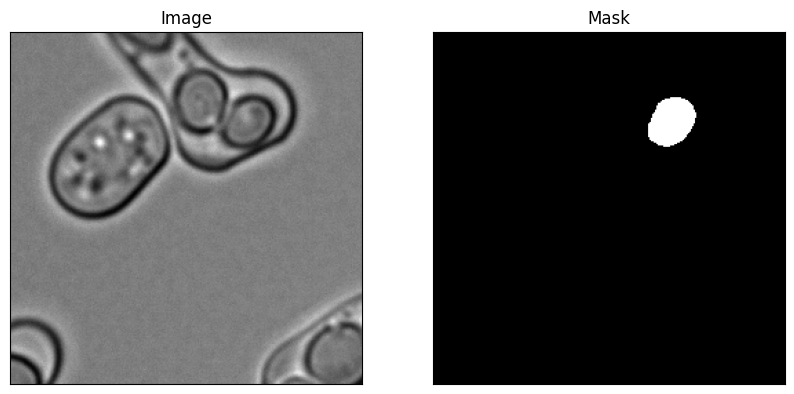

In [16]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [17]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]
    return bbox

from scipy.ndimage import binary_erosion
def get_points(ground_truth_map, n=1, patch=1):
    # get bounding box from mask
    gt_erosion = binary_erosion(ground_truth_map, structure=np.ones((7, 7))).astype(ground_truth_map.dtype)
    points = []
    labels = []
    for j in range(0, patch):
        point = []
        label = []
        y_indices, x_indices = np.where(gt_erosion > 0)
        index = np.random.randint(0, len(x_indices), n)
        for i in index:
            point.append([x_indices[i], y_indices[i]])
            label.append(1)
        points.append(point)
        labels.append(label)
    return points, labels
    # return bbox

In [18]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    """
    This class is used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])

        # get bounding box prompt
        # prompt_bbox = get_bounding_box(ground_truth_mask)
        prompt_point = get_points(ground_truth_mask, n=1, patch=16)
        # prepare image and prompt for the model
        #self.processor.set_image(image)
        inputs = self.processor(image,
                                # input_boxes=[[prompt]],
                                input_points = [prompt_point[0]],
                                input_labels = [prompt_point[1]],
                                return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [19]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [20]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [21]:
example = train_dataset[3]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([16, 1, 2])
input_labels torch.Size([16, 1])
ground_truth_mask (256, 256)


In [22]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=False)

In [23]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_points torch.Size([1, 16, 1, 2])
input_labels torch.Size([1, 16, 1])
ground_truth_mask torch.Size([1, 256, 256])


In [24]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-huge")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [25]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
# seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, squared_pred=True, batch=True, reduction='mean')
seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, squared_pred=True,reduction='none')

In [26]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

print(batch["input_points"].shape)
print(batch["input_labels"].shape)

torch.Size([1, 16, 1, 2])
torch.Size([1, 16, 1])


In [ ]:
for epoch in range(num_epochs):
    epoch_losses = []
    flag = 0
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_points=batch["input_points"].to(device),
                      input_labels=batch["input_labels"].to(device),
                      multimask_output=True)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(0)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device).expand(predicted_masks.shape)

        # loss = seg_loss(predicted_masks, ground_truth_masks)
        # loss = torch.mean(torch.min(torch.mean(loss, axis=(3,4)), dim=2)[0])
        loss = seg_loss(predicted_masks, ground_truth_masks)
        loss = torch.sum(torch.min(torch.mean(loss, axis=(2,3)), dim=1)[0])
        
        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

        del outputs
        del predicted_masks
        del ground_truth_masks
        flag += 1
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    if (epoch+1) % 10 == 0:
        torch.save(model.state_dict(), f"/media/wd/T7/data/for_sam_test/test_mito_model_checkpoint_1019_ep={epoch}.pth")

100%|███████████████████████████████████████████████████| 394/394 [06:45<00:00,  1.03s/it]


EPOCH: 0
Mean loss: 0.47785214017036604


100%|███████████████████████████████████████████████████| 394/394 [06:48<00:00,  1.04s/it]


EPOCH: 1
Mean loss: 0.4006538321996855


100%|███████████████████████████████████████████████████| 394/394 [06:48<00:00,  1.04s/it]


EPOCH: 2
Mean loss: 0.34603224019638174


100%|███████████████████████████████████████████████████| 394/394 [06:44<00:00,  1.03s/it]


EPOCH: 3
Mean loss: 0.3139467948130545


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 4
Mean loss: 0.29907256993583314


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 5
Mean loss: 0.2846579721509503


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 6
Mean loss: 0.2688796070550904


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 7
Mean loss: 0.24975415226544825


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 8
Mean loss: 0.2387707102381941


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 9
Mean loss: 0.23268402028393928


100%|███████████████████████████████████████████████████| 394/394 [06:43<00:00,  1.02s/it]


EPOCH: 10
Mean loss: 0.22406180129211567


100%|███████████████████████████████████████████████████| 394/394 [06:43<00:00,  1.02s/it]


EPOCH: 11
Mean loss: 0.22187060077064835


100%|███████████████████████████████████████████████████| 394/394 [06:43<00:00,  1.02s/it]


EPOCH: 12
Mean loss: 0.21549971460312756


100%|███████████████████████████████████████████████████| 394/394 [06:43<00:00,  1.02s/it]


EPOCH: 13
Mean loss: 0.20586152103384436


100%|███████████████████████████████████████████████████| 394/394 [06:43<00:00,  1.02s/it]


EPOCH: 14
Mean loss: 0.2085000532041044


100%|███████████████████████████████████████████████████| 394/394 [06:43<00:00,  1.02s/it]


EPOCH: 15
Mean loss: 0.20168334098182958


100%|███████████████████████████████████████████████████| 394/394 [06:43<00:00,  1.02s/it]


EPOCH: 16
Mean loss: 0.19090450055859415


100%|███████████████████████████████████████████████████| 394/394 [06:43<00:00,  1.02s/it]


EPOCH: 17
Mean loss: 0.18771592010436627


100%|███████████████████████████████████████████████████| 394/394 [06:43<00:00,  1.02s/it]


EPOCH: 18
Mean loss: 0.18269505228866176


100%|███████████████████████████████████████████████████| 394/394 [06:43<00:00,  1.02s/it]


EPOCH: 19
Mean loss: 0.1799316073904939


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 20
Mean loss: 0.174801962327231


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 21
Mean loss: 0.1763058592693001


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 22
Mean loss: 0.1743394783532559


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 23
Mean loss: 0.17240778071247986


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 24
Mean loss: 0.16115466956295035


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 25
Mean loss: 0.15480257948000117


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 26
Mean loss: 0.1545395814827856


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 27
Mean loss: 0.1554399059546478


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 28
Mean loss: 0.1506710507372763


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 29
Mean loss: 0.1482123527675867


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 30
Mean loss: 0.1463061992532862


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 31
Mean loss: 0.14854349153409452


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 32
Mean loss: 0.14446313929777158


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 33
Mean loss: 0.13840859391381444


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 34
Mean loss: 0.13653214887578777


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 35
Mean loss: 0.13544933887453853


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 36
Mean loss: 0.13249998755261377


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 37
Mean loss: 0.13271183815553103


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 38
Mean loss: 0.13108328918968964


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 39
Mean loss: 0.12553848913364907


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 40
Mean loss: 0.1225865892451351


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 41
Mean loss: 0.12580795170559647


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 42
Mean loss: 0.12427709546639834


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 43
Mean loss: 0.12259457620134964


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 44
Mean loss: 0.12377170425116411


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 45
Mean loss: 0.11835586061218971


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 46
Mean loss: 0.11364747176117022


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 47
Mean loss: 0.11281049183007273


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 48
Mean loss: 0.1154003302628165


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 49
Mean loss: 0.11470201461656293


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 50
Mean loss: 0.11055955546553516


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 51
Mean loss: 0.11105221088947302


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 52
Mean loss: 0.11409831936778453


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 53
Mean loss: 0.10985184309124796


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 54
Mean loss: 0.1049878007949798


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 55
Mean loss: 0.10179980227080775


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 56
Mean loss: 0.10043819429267783


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 57
Mean loss: 0.10601026746373492


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 58
Mean loss: 0.10819769224038508


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 59
Mean loss: 0.10458761023423696


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 60
Mean loss: 0.1002119870142548


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 61
Mean loss: 0.10003348141034053


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 62
Mean loss: 0.09882001500449092


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 63
Mean loss: 0.09594108249642296


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 64
Mean loss: 0.09611242843867483


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 65
Mean loss: 0.09623989045530142


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 66
Mean loss: 0.09377809388203745


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 67
Mean loss: 0.09433409838280096


100%|███████████████████████████████████████████████████| 394/394 [06:44<00:00,  1.03s/it]


EPOCH: 68
Mean loss: 0.09880426672859316


100%|███████████████████████████████████████████████████| 394/394 [06:43<00:00,  1.02s/it]


EPOCH: 69
Mean loss: 0.09223340597561547


100%|███████████████████████████████████████████████████| 394/394 [06:42<00:00,  1.02s/it]


EPOCH: 70
Mean loss: 0.08888061966175015


 85%|███████████████████████████████████████████▍       | 336/394 [05:48<01:02,  1.08s/it]

In [ ]:
torch.save(model.state_dict(), f"/media/wd/T7/data/for_sam_test/test_mito_model_checkpoint_1020.pth")

In [23]:
# ## plot process
# medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# medsam_seg_prob = medsam_seg_prob.cpu().detach().numpy().squeeze()
# medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
# mesam_scores = outputs['iou_scores'].cpu().detach().numpy().squeeze()
# predicted_masks = outputs.pred_masks.squeeze(0).cpu().detach().numpy()
# ground_truth_masks = batch["ground_truth_mask"]
# org = batch["pixel_values"].squeeze()[0].cpu().detach().numpy()
# prompt = batch["input_points"].squeeze().cpu().detach().numpy()

# fig,axs = plt.subplots(2,3,figsize=(9,6))
# axs[0,0].imshow(org,"gray")
# axs[0,0].scatter(prompt[0,0], prompt[0,1],
#                   color='green', marker='*', s=500, edgecolor='white', linewidth=1.25)
# axs[0,1].imshow(ground_truth_masks[0])
# axs[0,1].set_title("GT")
# axs[0,2].imshow(predicted_masks[0].sum(axis=0))
# axs[0,2].set_title("Prob")
# for i in range(0,3):
#     axs[1,i].imshow(medsam_seg_prob[0,i])
#     axs[1,i].set_title(f"s = {mesam_scores[0,i]:.4f}")
# fig.suptitle(f"epoch = {epoch}, loss={loss}")
# for axi in axs:
#     for ax in axi:
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
# fig.tight_layout()
# plt.savefig(f"/home/wd/Pictures/overfit_epoch{epoch}_{flag}.png")
# plt.close()

In [51]:
torch.save(model.state_dict(), "/media/wd/T7/data/for_sam_test/test_mito_model_checkpoint_1019.pth")

# test

In [12]:
from transformers import SamModel, SamConfig, SamProcessor
import torch
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

## new model

In [13]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-huge")
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")


# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/media/wlli/T7/data/for_sam_test/test_mito_model_checkpoint_1019_cpu.pth"))

# set the device to cuda if available, otherwise use cpu
device = "cpu"
my_mito_model.to(device)
print("loaded")

loaded


## pre model

In [14]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

#sam_checkpoint = "/home/wlli/Data/mito_model_checkpoint_oldname.pth"
sam_checkpoint = "../models/sam_vit_h_4b8939.pth"

model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

sam.load_state_dict(torch.load(sam_checkpoint))

sam.to(device=device)

predictor = SamPredictor(sam)

## new name space model

In [27]:
# import sys
# sys.path.append("..")
# from segment_anything import sam_model_registry, SamPredictor

# #sam_checkpoint = "/home/wlli/Data/mito_model_checkpoint_oldname.pth"
# sam_checkpoint2 = "/home/wd/data/test_mito_model_checkpoint_1018_oldnamespace.pth"

# model_type = "vit_h"

# device = "cpu"

# sam2 = sam_model_registry[model_type](checkpoint=sam_checkpoint2)

# sam2.load_state_dict(torch.load(sam_checkpoint2))

# sam2.to(device=device)

# predictor2 = SamPredictor(sam2)

## image

Text(0.5, 1.0, 'Mask')

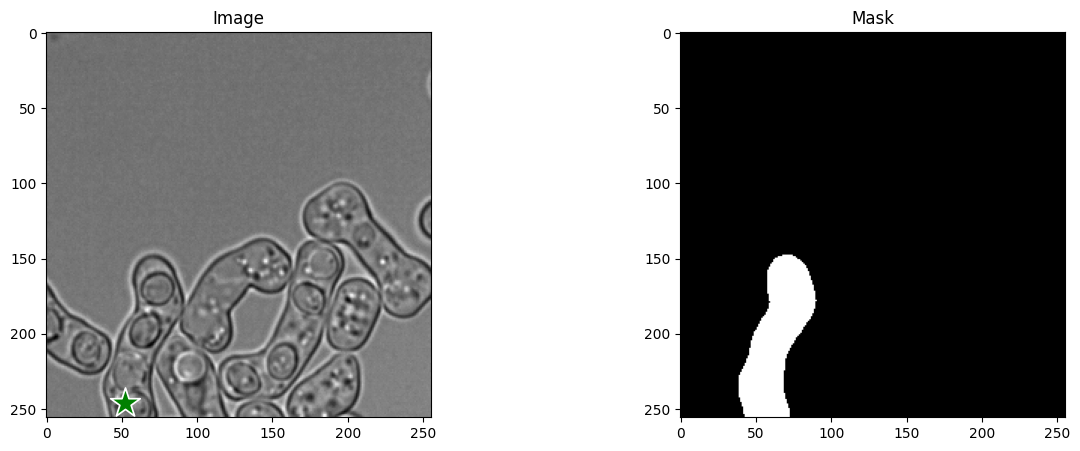

In [82]:
idx = 321
test_image = dataset[idx]["image"]
test_mask = dataset[idx]["label"]
prompt = get_points(np.array(test_mask))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")
axes[0].scatter(np.array(prompt[0][0])[:,0], np.array(prompt[0][0])[:,1],
                  color='green', marker='*', s=500, edgecolor='white', linewidth=1.25)

# Plot the second image on the right
axes[1].imshow(test_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

## me-sam

In [83]:
# let's take a random training example

# get box prompt based on ground truth segmentation map
#prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image,
                   #input_boxes=[[prompt]],
                   input_points = [prompt[0]],
                   input_labels = [prompt[1]],
                   return_tensors="pt",
                   multimask_output=True)

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=True)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
mesam_scores = outputs['iou_scores'].numpy().squeeze()
mesam_logits = outputs.pred_masks.squeeze(1).cpu().numpy()[0]

## sam

In [84]:
predictor.set_image(cv2.cvtColor(np.array(test_image), cv2.COLOR_GRAY2RGB))
masks, scores, logits = predictor.predict(
    point_coords=np.array(prompt[0][0]),
    point_labels=np.array(prompt[1][0]),
    multimask_output=True,
)
predictor.reset_image()

In [85]:
# predictor2.set_image(cv2.cvtColor(np.array(test_image), cv2.COLOR_GRAY2RGB))
# masks2, scores2, logits2 = predictor2.predict(
#     point_coords=np.array(prompt[0][0]),
#     point_labels=np.array(prompt[1][0]),
#     multimask_output=True,
# )
# predictor2.reset_image()

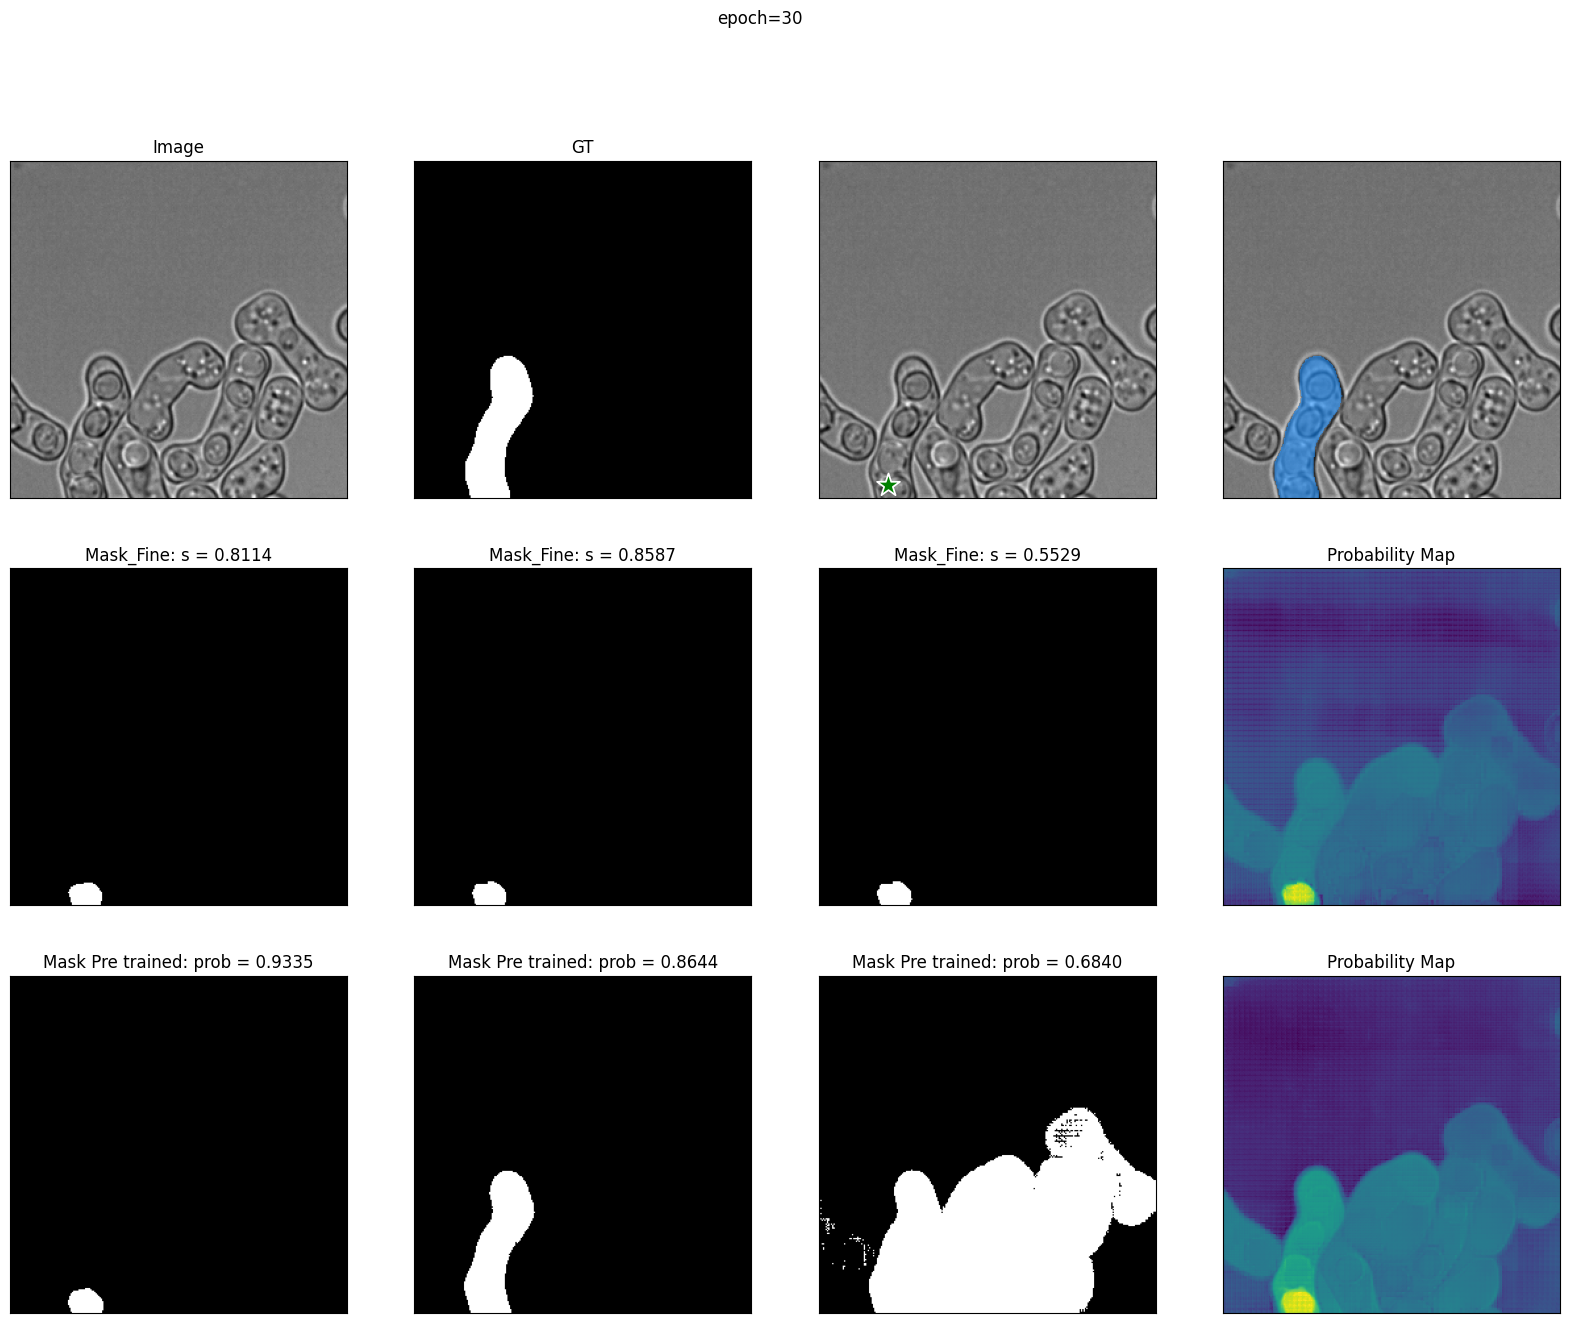

In [86]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Plot the first image on the left
axes[0,0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0,0].set_title("Image")

axes[0,1].imshow(np.array(test_mask), cmap='gray')  # Assuming the first image is grayscale
axes[0,1].set_title("GT")

axes[0,2].imshow(np.array(test_image), cmap='gray')
axes[0,2].scatter(np.array(prompt[0][0])[:,0], np.array(prompt[0][0])[:,1],
                  color='green', marker='*', s=300, edgecolor='white', linewidth=1.25)

axes[0,3].imshow(np.array(test_image), cmap='gray')
show_mask(np.array(test_mask), axes[0,3])

# Plot the second image on the right
for i in range(0, 3):
    axes[1, i].imshow(medsam_seg[i], cmap='gray')  # Assuming the second image is grayscale
    axes[1, i].set_title(f"Mask_Fine: s = {mesam_scores[i]:.4f}")
# Plot the second image on the right
axes[1, 3].imshow(mesam_logits.sum(axis=0))  # Assuming the second image is grayscale
axes[1, 3].set_title("Probability Map")

for i in range(0, 3):
    axes[2, i].imshow(masks[i], cmap='gray')
    axes[2, i].set_title(f"Mask Pre trained: prob = {scores[i]:.4f}")
# Plot the second image on the right
axes[2, 3].imshow(logits.sum(axis=0))
axes[2, 3].set_title("Probability Map")

# for i in range(0, 3):
#     axes[3, i].imshow(masks2[i], cmap='gray')
#     axes[3, i].set_title(f"Mask old name splace: prob = {scores2[i]:.4f}")
# # Plot the second image on the right
# axes[3, 3].imshow(logits2.sum(axis=0))
# axes[3, 3].set_title("Probability Map")

# Hide axis ticks and labels
for axi in axes:
    for ax in axi:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

# Display the images side by side
#plt.savefig("/home/wd/Pictures/1018_vs_fineturning_ep7.png")
fig.suptitle("epoch=30")
plt.show()


## checkpoint name space

In [41]:
import re
import copy

KEYS_TO_MODIFY_MAPPING = {
    "iou_prediction_head.layers.0": "iou_prediction_head.proj_in",
    "iou_prediction_head.layers.1": "iou_prediction_head.layers.0",
    "iou_prediction_head.layers.2": "iou_prediction_head.proj_out",
    "mask_decoder.output_upscaling.0": "mask_decoder.upscale_conv1",
    "mask_decoder.output_upscaling.1": "mask_decoder.upscale_layer_norm",
    "mask_decoder.output_upscaling.3": "mask_decoder.upscale_conv2",
    "mask_downscaling.0": "mask_embed.conv1",
    "mask_downscaling.1": "mask_embed.layer_norm1",
    "mask_downscaling.3": "mask_embed.conv2",
    "mask_downscaling.4": "mask_embed.layer_norm2",
    "mask_downscaling.6": "mask_embed.conv3",
    "point_embeddings": "point_embed",
    "pe_layer.positional_encoding_gaussian_matrix": "shared_embedding.positional_embedding",
    "image_encoder": "vision_encoder",
    "neck.0": "neck.conv1",
    "neck.1": "neck.layer_norm1",
    "neck.2": "neck.conv2",
    "neck.3": "neck.layer_norm2",
    "patch_embed.proj": "patch_embed.projection",
    ".norm": ".layer_norm",
    "blocks": "layers",
}

def change_name(self_trained_path, pre_trained_path, save_path):
    pre_trained = torch.load(pre_trained_path)
    self_trained = torch.load(self_trained_path)
    
    state_dict = pre_trained
    model_state_dict = self_trained
    
    to_old_name_dict = {}
    state_dict.pop("pixel_mean", None)
    state_dict.pop("pixel_std", None)
    
    output_hypernetworks_mlps_pattern = r".*.output_hypernetworks_mlps.(\d+).layers.(\d+).*"
    
    for key, value in state_dict.items():
        m_key = copy.copy(key)
        for key_to_modify, new_key in KEYS_TO_MODIFY_MAPPING.items():
            if key_to_modify in key:
                m_key= m_key.replace(key_to_modify, new_key)
        if re.match(output_hypernetworks_mlps_pattern, m_key):
            layer_nb = int(re.match(output_hypernetworks_mlps_pattern, m_key).group(2))
            if layer_nb == 0:
                m_key = m_key.replace("layers.0", "proj_in")
            elif layer_nb == 1:
                m_key = m_key.replace("layers.1", "layers.0")
            elif layer_nb == 2:
                m_key = m_key.replace("layers.2", "proj_out")
    
        to_old_name_dict[key] = model_state_dict[m_key]

    torch.save(to_old_name_dict, save_path)


# to cpus version
# aaa = torch.load("/media/wlli/T7/data/for_sam_test/mito_model_checkpoint_1018_oldname.pth", map_location=torch.device('cpu'))
# torch.save(aaa, "/media/wlli/T7/data/for_sam_test/mito_model_checkpoint_1018_cpu.pth")

In [42]:
change_name("/home/wd/data/test_mito_model_checkpoint_1018_3.pth",
            "../models/sam_vit_h_4b8939.pth",
            "/home/wd/data/test_mito_model_checkpoint_1018_3_oldnamespace.pth"
           )

In [262]:
#to cpus version
aaa = torch.load("/media/wlli/T7/data/for_sam_test/test_mito_model_checkpoint_1019.pth", map_location=torch.device('cpu'))
torch.save(aaa, "/media/wlli/T7/data/for_sam_test/test_mito_model_checkpoint_1019_cpu.pth")